# Stokes flow in a lid-driven cavity

$$\textbf{u}|_{x,y=L_y}=u_{\text{lid}}\textbf{e}_x$$

$$\textbf{u}|_{x,y=0}=\textbf{u}|_{x=0,y}=\textbf{u}|_{x=L_x,y}=\textbf{0}$$

$$p(x=0, y=0)=0$$

Without any natural boundary conditions, the pressure is only defined up to a constant so we also constrain the pressure at a point.

In [ ]:
from lucifex.mesh import rectangle_mesh, mesh_boundary
from lucifex.fem import LUCiFExFunction as Function, LUCiFExConstant as Constant
from lucifex.solver import bvp_solver, BoundaryConditions, OptionsPETSc
from lucifex.utils import fem_function_components
from lucifex.viz import plot_colormap, plot_streamlines
from lucifex.io import write

from lucifex.pde.stokes import stokes_incompressible


Lx = 1.0
Ly = 1.0
mesh = rectangle_mesh(Lx, Ly, 64, 64, cell='quadrilateral')
boundary = mesh_boundary(
    mesh, 
    {
        "left": lambda x: x[0],
        "right": lambda x: x[0] - Lx,
        "lower": lambda x: x[1],
        "upper": lambda x: x[1] - Ly,
    },
)
mu = Constant(mesh, 1.0, 'mu')

u_elem = ('P', 2, 2)
p_elem = ('P', 1)
u_p_elem = [u_elem, p_elem]
up = Function((mesh, u_p_elem), name="up")

import numpy as np
u_lid = 1.0
bcs = BoundaryConditions(
    ('essential', boundary['upper'], (u_lid, 0.0), 0),
    ('essential', boundary['left', 'right', 'lower'], (0.0, 0.0), 0),
    ('essential', lambda x: np.isclose(x[0], 0.0) & np.isclose(x[1], 0.0), 0.0, 1),
    dofs_method='geometrical',
)

petsc = OptionsPETSc(pc_type='lu')
petsc['pc_factor_mat_solver_type'] = 'mumps'
up_solver = bvp_solver(stokes_incompressible, bcs, petsc)(up, mu)
up_solver.solve()

u, p = up.split(('u', 'p'), collapse=True)
ux, uy = fem_function_components(('P', 1), u, names=('ux', 'uy'))

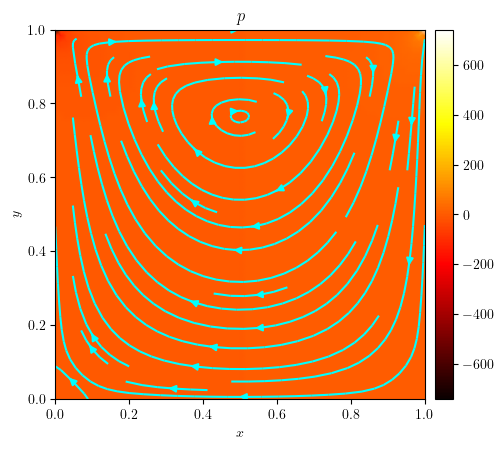

: 

In [ ]:
fig, ax = plot_colormap(p, title='$p$', x_label='$x$', y_label='$y$')
plot_streamlines(fig, ax, (ux, uy), density=0.75, color='cyan')
write(fig, f'A11_stokes_lid_driven_cavity', './figures', close=False, pickle=False)